In [1]:
# Ignoring warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Imports, as always...

import pandas as pd
import numpy as np

from tqdm import tqdm

# PyTorch (+ Geometric)
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv

# Visualisation.
import matplotlib.pyplot as plt
import seaborn as sns

# Script imports.
from scripts.training import train, evaluate
from scripts.utils import produce_reduced_embeddings, plot_reduced_embeddings
from scripts import models

In [3]:
# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('Set2')

In [4]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Set RNG.
torch.manual_seed(42)

In [6]:
# Dataset.
from torch_geometric.datasets import Planetoid

dataset = Planetoid(
    root='./',
    name='CiteSeer',
    split='public',
    transform=torch_geometric.transforms.GCNNorm()
  )

print(dataset.data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


# Training

This notebook will define and train up GNN architectures using different forms of residual connections; those being: (1) **None**, (2) **fixed-weight**, (3) **freely-learnt** (or unconstrained), (4) **hierarchically-weighted**, and (5) **cluster-keeping**. 

We may also vary the underlying diffusion type; e.g. convolutional, attention-based, etc.

In [7]:
# Invariable hyperparameters.
n_nodes = dataset.data.x.size(0)
model_depths = range(1, 21)
aggregation_function = GCNConv
hid_dim = 64
dropout_ratio = .1
act_fn = F.relu
epochs = 100
max_patience = epochs // 10
lr = 1e-3

## None

In [11]:
# Define a set of GCN models of different depths.
none_models = [
    models.BackboneModel(
        residual_method=None,
        aggregation_function=aggregation_function,
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=hid_dim,
        n_classes=dataset.num_classes,
        n_layers=depth,
        dropout_ratio=dropout_ratio,
        act_fn=act_fn
    )
    for depth in model_depths
]

# Train them.
none_stats = {}
for model in tqdm(none_models):
    none_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=epochs,
        max_patience=max_patience,
        lr=lr,
        progress_bar=False,
        verbose=False
    )

100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


In [15]:
# Save the models' weights.
for model in none_models:
    depth = model.n_layers
    torch.save(model.state_dict(), f'./models/gcn/none_{depth}.pt')   

In [12]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_none_model = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in none_models if model.n_layers % 5 == 0
}

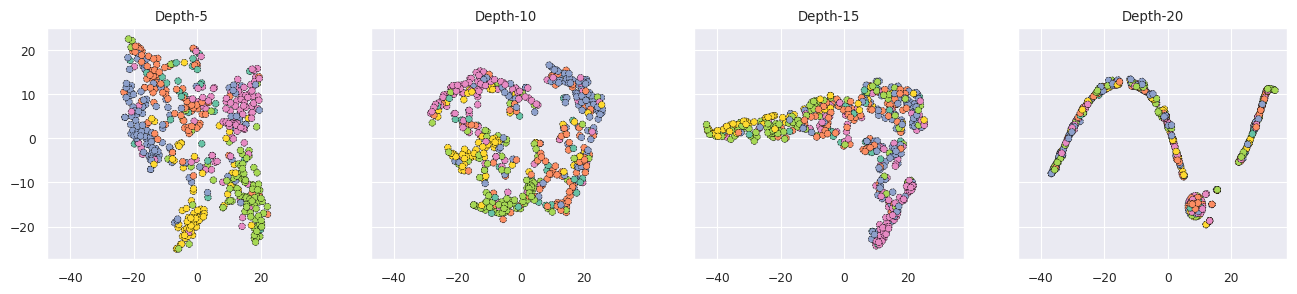

In [14]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_none_model)

# Save figure.
plt.savefig('./figures/convergence/none.pdf', bbox_inches='tight')

## Fixed-weight

We have theoretical results for fixed weights of $1/2$, so that is what we will use here.

In [16]:
# Define a set of GCN models of different depths.
fixed_models = [
    models.BackboneModel(
        residual_method=lambda *args: models.FixedRC(torch.ones(n_nodes)/2, *args),
        aggregation_function=aggregation_function,
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=hid_dim,
        n_classes=dataset.num_classes,
        n_layers=depth,
        dropout_ratio=dropout_ratio,
        act_fn=act_fn
    )
    for depth in model_depths
]

# Train them.
fixed_stats = {}
for model in tqdm(fixed_models):
    fixed_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=epochs,
        max_patience=max_patience,
        lr=lr,
        progress_bar=False,
        verbose=False
    )

100%|██████████| 20/20 [04:50<00:00, 14.53s/it]


In [17]:
# Save the models' weights.
for model in fixed_models:
    depth = model.n_layers
    torch.save(model.state_dict(), f'./models/gcn/fixed_{depth}.pt')   

In [18]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_fixed_model = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in fixed_models if model.n_layers % 5 == 0
}

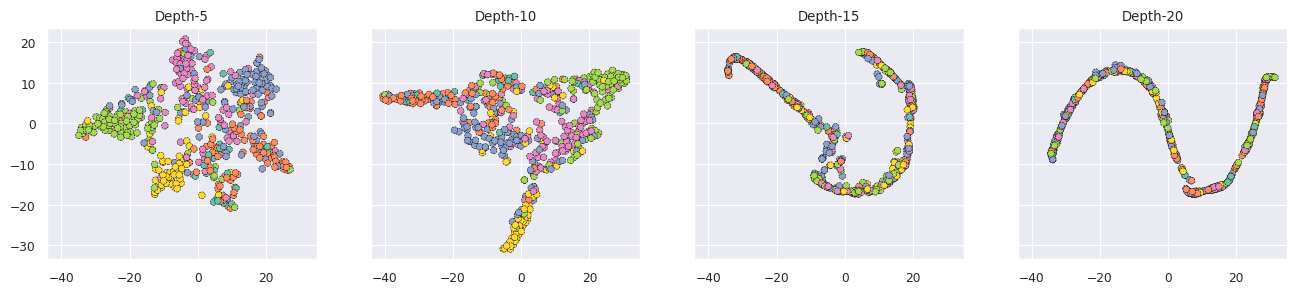

In [20]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_fixed_model)

# Save figure.
plt.savefig('./figures/convergence/fixed.pdf', bbox_inches='tight')

## Freely-learnt

In [ ]:
# Define a set of GCN models of different depths.
free_models = [
    models.BackboneModel(
        residual_method=models.FreeRC,
        aggregation_function=aggregation_function,
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=hid_dim,
        n_classes=dataset.num_classes,
        n_layers=depth,
        dropout_ratio=dropout_ratio,
        act_fn=act_fn
    )
    for depth in model_depths
]

# Train them.
free_stats = {}
for model in tqdm(free_models):
    free_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=epochs,
        max_patience=max_patience,
        lr=lr,
        progress_bar=False,
        verbose=False
    )
    
    # Save the model weights as we go.
    torch.save(model.state_dict(), f'./models/gcn/free_{model.n_layers}.pt')   

In [29]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_free_model = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in free_models if model.n_layers % 5 == 0
}

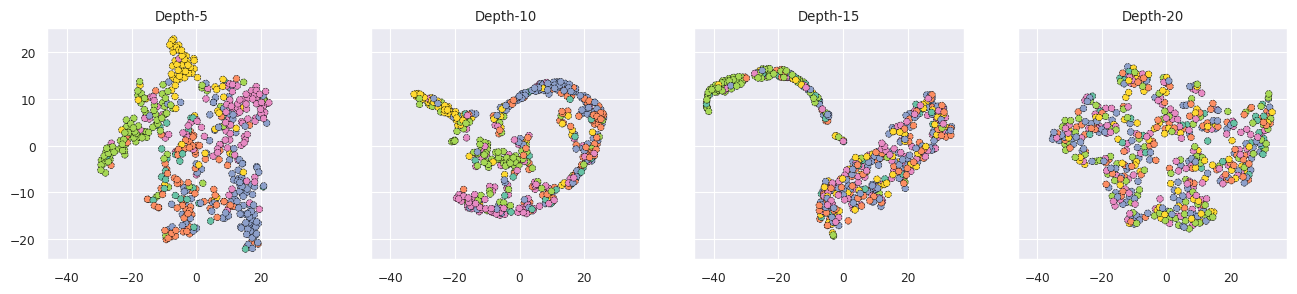

In [31]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_free_model)

# Save figure.
plt.savefig('./figures/convergence/free.pdf', bbox_inches='tight')

## Hierarchically-weighted

In [ ]:
# Define a set of GCN models of different depths.
hierarchical_models = [
    models.BackboneModel(
        residual_method=models.HierarchicalRC,
        aggregation_function=aggregation_function,
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=hid_dim,
        n_classes=dataset.num_classes,
        n_layers=depth,
        dropout_ratio=dropout_ratio,
        act_fn=act_fn
    )
    for depth in model_depths
]

# Train them.
hierarchical_stats = {}
for model in tqdm(hierarchical_models):
    hierarchical_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=epochs,
        max_patience=max_patience,
        lr=lr,
        progress_bar=True,
        verbose=False
    )
    
    # Save the model weights as we go.
    torch.save(model.state_dict(), f'./models/gcn/hierarchical_{model.n_layers}.pt')   

In [10]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_hierarchical_model = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in hierarchical_models if model.n_layers % 5 == 0
}

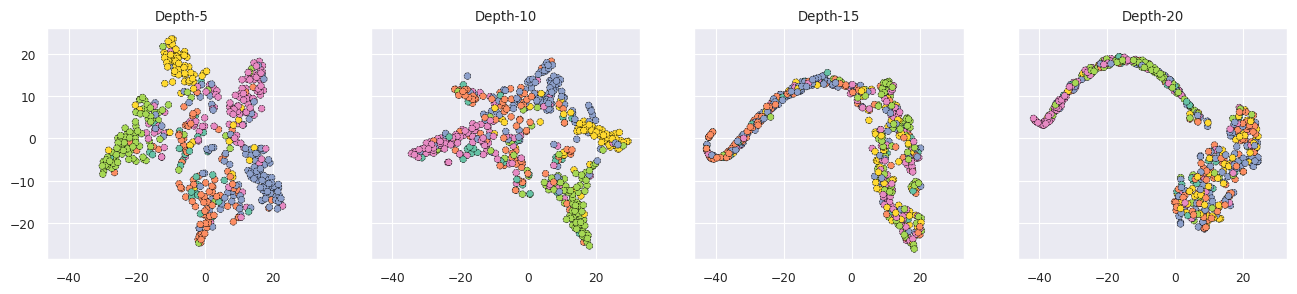

In [12]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_hierarchical_model)

# Save figure.
plt.savefig('./figures/convergence/hierarchical.pdf', bbox_inches='tight')

## Cluster-keeping

In [ ]:
# Define a set of GCN models of different depths.
cluster_models = [
    models.BackboneModel(
        residual_method=models.ClusterKeepingRC,
        aggregation_function=aggregation_function,
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=hid_dim,
        n_classes=dataset.num_classes,
        n_layers=depth,
        dropout_ratio=dropout_ratio,
        act_fn=act_fn,
        L_0=2 # Give an extra layer before cluster keeping.
    )
    for depth in model_depths
]

# Train them.
cluster_stats = {}
for model in tqdm(cluster_models):
    cluster_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=epochs,
        max_patience=max_patience,
        lr=lr,
        progress_bar=True,
        verbose=False
    )
    
    # Save the model weights as we go.
    torch.save(model.state_dict(), f'./models/gcn/cluster_{model.n_layers}.pt')   

In [30]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_cluster_model = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in cluster_models if model.n_layers % 5 == 0
}

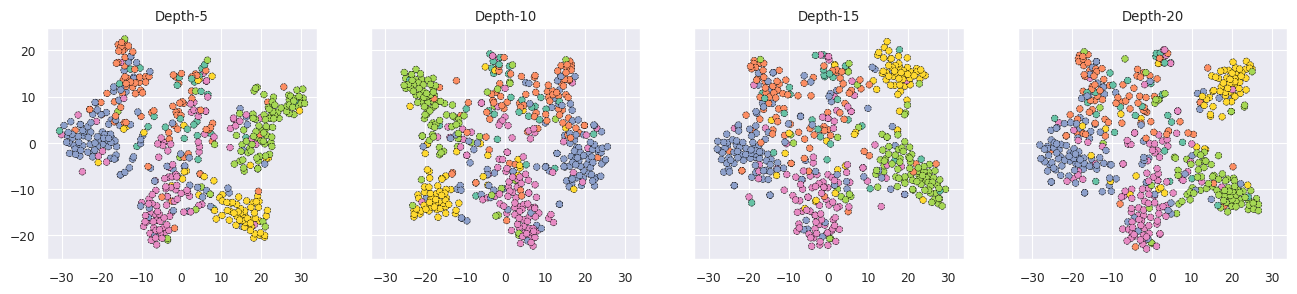

In [32]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_cluster_model)

# Save figure.
plt.savefig('./figures/convergence/cluster.pdf', bbox_inches='tight')

## Saving the Training Data

In [9]:
#for depth, stats in none_stats.items():
#    stats_df = pd.DataFrame(stats)
#    stats_df.to_csv(f'./data/gcn/none_{depth}.csv', index=False)
    
#for depth, stats in fixed_stats.items():
#    stats_df = pd.DataFrame(stats)
#    stats_df.to_csv(f'./data/gcn/fixed_{depth}.csv', index=False)
    
#for depth, stats in free_stats.items():
#    stats_df = pd.DataFrame(stats)
#    stats_df.to_csv(f'./data/gcn/free_{depth}.csv', index=False)
    
#for depth, stats in hierarchical_stats.items():
#    stats_df = pd.DataFrame(stats)
#    stats_df.to_csv(f'./data/gcn/hierarchical_{depth}.csv', index=False)
    
#for depth, stats in cluster_stats.items():
#    stats_df = pd.DataFrame(stats)
#    stats_df.to_csv(f'./data/gcn/cluster_{depth}.csv', index=False)

# Training Curves

In [8]:
from os import walk, path

In [9]:
# Merge all training statistics into a single dataframe.
master_stats_df = pd.DataFrame(columns=['train_acc', 'train_loss', 'val_acc', 'val_loss', 'residual_method', 'model_depth'])

for file in next(walk('./data/gcn'), (None, None, []))[2]:
    stats_df = pd.read_csv(path.join('./data/gcn', file))
    residual_method, model_depth = file[:-4].split('_')
    stats_df['residual_method'] = residual_method
    stats_df['model_depth'] = int(model_depth)
    master_stats_df = pd.concat([master_stats_df, stats_df])

In [10]:
# Add an epoch column.
master_stats_df['epoch'] = list(range(100)) * 100
master_stats_df

,train_acc,train_loss,val_acc,val_loss,residual_method,model_depth,epoch
0,0.191667,1.772310,0.168,1.795599,cluster,1,0
1,0.333333,1.746219,0.190,1.787844,cluster,1,1
2,0.441667,1.720325,0.222,1.780173,cluster,1,2
3,0.591667,1.694634,0.244,1.772592,cluster,1,3
4,0.666667,1.669150,0.272,1.765098,cluster,1,4
...,...,...,...,...,...,...,...
95,0.975000,0.061570,0.580,3.548295,none,9,95
96,0.975000,0.052588,0.578,3.646541,none,9,96
97,0.958333,0.067533,0.574,3.847554,none,9,97
98,0.966667,0.070406,0.564,3.926977,none,9,98


In [11]:
depths = [5, 10, 15, 20]

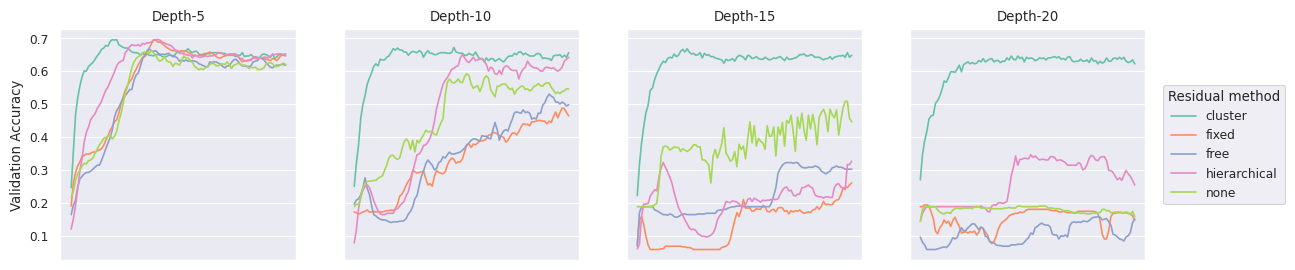

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3), sharex='all', sharey='all')

for ax, depth in zip(axes, depths):
    sns.lineplot(
        data=master_stats_df[master_stats_df['model_depth'] == depth],
        x='epoch', y='val_acc',
        hue='residual_method',
        palette='Set2',
        ax=ax
    )

    # Remove clutter.
    ax.legend([], [], frameon=False)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_ylabel('')

    # Add titles.
    ax.set_title(f'Depth-{depth}')
    
axes[0].set_ylabel('Validation Accuracy')
    
axes[-1].legend(
    bbox_to_anchor=(1.05, .5),
    loc='center left',
    title='Residual method'
)

# Save figure.
plt.savefig('./figures/curves/models-val-acc-by-depth.pdf', bbox_inches='tight')

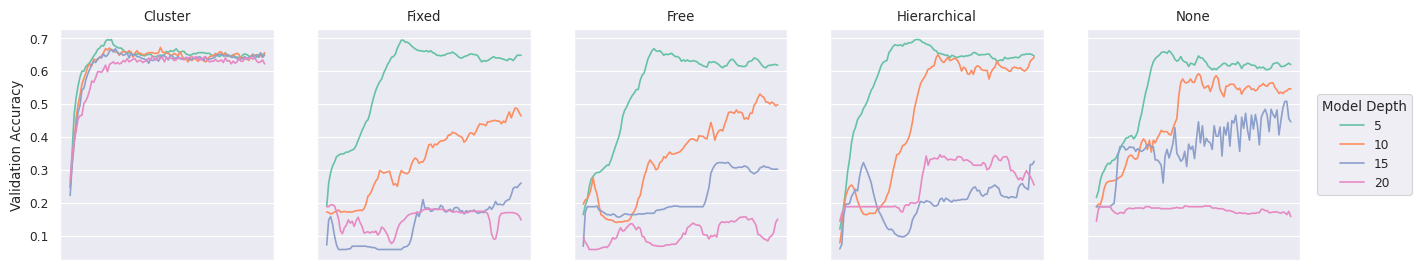

In [43]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex='all', sharey='all')

# Only consider a few depths.
trimmed_df = master_stats_df[master_stats_df['model_depth'].isin(depths)]

for ax, method in zip(axes, sorted(trimmed_df.residual_method.unique())):
    sns.lineplot(
        data=trimmed_df[trimmed_df['residual_method'] == method],
        x='epoch', y='val_acc',
        hue='model_depth',
        palette='Set2',
        ax=ax
    )

    # Remove clutter.
    ax.legend([], [], frameon=False)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_ylabel('')

    # Add titles.
    ax.set_title(method.capitalize())
    
axes[0].set_ylabel('Validation Accuracy')
    
axes[-1].legend(
    bbox_to_anchor=(1.05, .5),
    loc='center left',
    title='Model Depth'
)

# Save figure.
plt.savefig('./figures/curves/depth-val-acc-by-model.pdf', bbox_inches='tight')

In [13]:
master_stats_df['residual_method'].unique()

array(['cluster', 'fixed', 'free', 'hierarchical', 'none'], dtype=object)

Text(0.5, 1.05, 'Generalisation Gap (by Residual Method) at Depth-10')

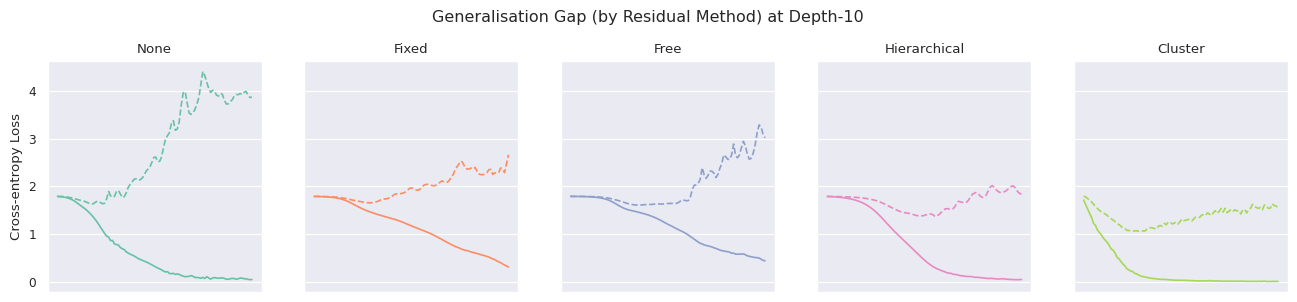

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex='all', sharey='all')

colours = sns.color_palette('Set2', 5)
for i, (ax, method) in enumerate(zip(axes, ['None', 'Fixed', 'Free', 'Hierarchical', 'Cluster'])):
    data = master_stats_df[master_stats_df['residual_method'] == method.lower()]
    data = data[data['model_depth'] == 10]
    sns.lineplot(
        data=data,
        x='epoch', y='train_loss',
        color=colours[i],
        ax=ax
    )
    sns.lineplot(
        data=data,
        x='epoch', y='val_loss',
        linestyle='--', color=colours[i],
        ax=ax
    )

    # Remove clutter.
    ax.legend([], [], frameon=False)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_ylabel('')

    # Add titles.
    ax.set_title(method.capitalize())
    
axes[0].set_ylabel('Cross-entropy Loss')
fig.suptitle('Generalisation Gap (by Residual Method) at Depth-10', y=1.05)

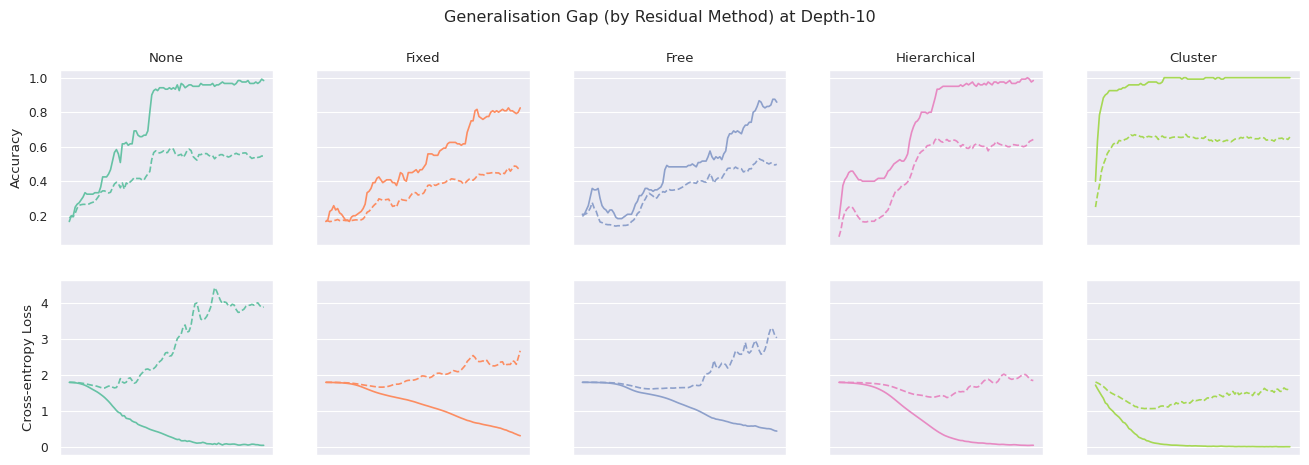

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(16, 5), sharex='all', sharey='row')

colours = sns.color_palette('Set2', 5)
for i, method in enumerate(['None', 'Fixed', 'Free', 'Hierarchical', 'Cluster']):
    data = master_stats_df[master_stats_df['residual_method'] == method.lower()]
    data = data[data['model_depth'] == 10]
    sns.lineplot(
        data=data,
        x='epoch', y='train_acc',
        color=colours[i],
        ax=axes[0][i]
    )
    sns.lineplot(
        data=data,
        x='epoch', y='val_acc',
        linestyle='--', color=colours[i],
        ax=axes[0][i]
    )
    sns.lineplot(
        data=data,
        x='epoch', y='train_loss',
        color=colours[i],
        ax=axes[1][i]
    )
    sns.lineplot(
        data=data,
        x='epoch', y='val_loss',
        linestyle='--', color=colours[i],
        ax=axes[1][i]
    )

    # Remove clutter.
    axes[1][i].set_xlabel('')
    axes[1][i].set_xticks([])

    # Add titles.
    axes[0][i].set_title(method.capitalize())
  
axes[0][0].set_ylabel('Accuracy')  
axes[1][0].set_ylabel('Cross-entropy Loss')
fig.suptitle('Generalisation Gap (by Residual Method) at Depth-10', y=1)

# Save figure.
plt.savefig('./figures/curves/generalisation-gap-by-model.pdf', bbox_inches='tight')

In [20]:
master_stats_df[(master_stats_df.epoch == 99) & (master_stats_df.model_depth.isin(depths))]

,train_acc,train_loss,val_acc,val_loss,residual_method,model_depth,epoch
99,1.000000,0.007420,0.656,1.550463,cluster,10,99
99,1.000000,0.014487,0.648,1.553681,cluster,15,99
99,1.000000,0.023726,0.622,1.531780,cluster,20,99
99,1.000000,0.007840,0.652,1.335494,cluster,5,99
99,0.825000,0.312158,0.464,2.664792,fixed,10,99
99,0.433333,1.267922,0.260,1.990917,fixed,15,99
99,0.183333,1.784695,0.148,1.794790,fixed,20,99
99,1.000000,0.023457,0.648,1.333020,fixed,5,99
99,0.858333,0.440540,0.498,3.022168,free,10,99
99,0.350000,1.406830,0.302,1.926713,free,15,99


In [32]:
# A custom colour palette function (thank you Gemini). 
import colorsys

def darken_rgb(rgb_color, amount=0.3):
    """
    Darken an RGB color by reducing its lightness in the HSL space.
    
    Parameters:
        rgb_color (tuple): The input RGB color as a tuple (R, G, B), where each component is in the range [0, 1].
        amount (float): How much to darken the color (0 to 1). Higher values result in a darker color.
        
    Returns:
        tuple: The darkened RGB color as a tuple (R, G, B).
    """
    r, g, b = rgb_color
    
    # Convert RGB to HLS
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Darken by reducing the lightness
    l = max(0, l - amount)
    
    # Convert back to RGB
    return colorsys.hls_to_rgb(h, l, s)

def create_shades_palette_with_custom_start_rgb(rgb_color, n_shades=10, dark_amount=0.3):
    """
    Create a palette of shades starting from a darkened version of the given color to the color itself.
    
    Parameters:
        rgb_color (tuple): The input RGB color as a tuple (R, G, B), where each component is in the range [0, 1].
        n_shades (int): Number of shades to generate.
        dark_amount (float): Amount to darken the starting color (0 to 1).
        
    Returns:
        List of RGB tuples representing the shades.
    """
    start_color = darken_rgb(rgb_color, amount=dark_amount)
    palette = sns.blend_palette([start_color, rgb_color], n_shades)
    return palette

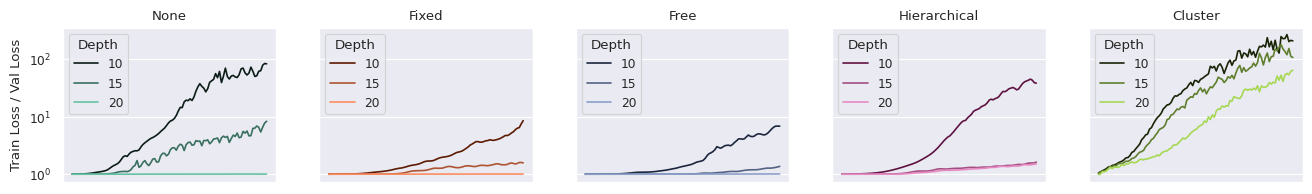

In [60]:
# Plotting the ratio of train vs val acc and train vs val loss.
fig, axes = plt.subplots(1, 5, figsize=(16, 2), sharex='all', sharey='row')

depths = [10, 15, 20]
colours = sns.color_palette('Set2', 5)
for i, method in enumerate(['None', 'Fixed', 'Free', 'Hierarchical', 'Cluster']):
    data = master_stats_df[(master_stats_df.residual_method == method.lower()) & (master_stats_df.model_depth.isin(depths))]
    data['loss_ratio'] = data['val_loss'] / data['train_loss']
    shades = create_shades_palette_with_custom_start_rgb(colours[i], n_shades=len(depths), dark_amount=0.5)
    
    sns.lineplot(
        data=data,
        x='epoch',
        y='loss_ratio',
        hue='model_depth',
        palette=shades,
        ax=axes[i]
    )
    axes[i].legend(loc='upper left', title='Depth')
    axes[i].set_yscale('log')
    
    # Remove clutter.
    axes[i].set_xlabel('')
    axes[i].set_xticks([])

    # Add titles.
    axes[i].set_title(method.capitalize())
  
axes[0].set_ylabel('Train Loss / Val Loss')

# Save figure.
plt.savefig('./figures/curves/ratios-by-model.pdf', bbox_inches='tight')